# Dataset Preparation & Preprocessing

In [1]:
import torch
import numpy as np
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [2]:
# import kagglehub

# # Download latest version
# style_path = kagglehub.dataset_download("ikarus777/best-artworks-of-all-time")
# print("Path to dataset files:", style_path)

In [3]:
import kagglehub

# # Download latest version
content_path = kagglehub.dataset_download("starktony45/image-dataset")
content_dir = f"{content_path}/train2014"
print("Path to MS COCO dataset files:", content_dir)

100%|██████████| 12.5G/12.5G [05:27<00:00, 41.0MB/s]

Extracting files...


Path to MS COCO dataset files: /root/.cache/kagglehub/datasets/starktony45/image-dataset/versions/1/train2014


In [4]:
IMAGENET_MEAN_1 = np.array([0.485, 0.456, 0.406])
IMAGENET_STD_1 = np.array([0.229, 0.224, 0.225])
IMAGENET_MEAN_255 = np.array([123.675, 116.28, 103.53])
# Usually when normalizing 0..255 images only mean-normalization is performed -> that's why standard dev is all 1s here
IMAGENET_STD_NEUTRAL = np.array([1, 1, 1])

IMAGE_SIZE = 256
BATCH_SIZE = 4

In [5]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

def get_transform(image_size=256, normalize=True, is_255_range=False):
    transform_list = [
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()   # Scales to float32 [0, 1]
    ]
    if is_255_range:
        transform_list.append(transforms.Lambda(lambda x: x * 255))
    if normalize:
        transform_list.append(transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL) if is_255_range else transforms.Normalize(mean=IMAGENET_MEAN_1, std=IMAGENET_STD_1))
    return transforms.Compose(transform_list)

# Custom Image Folder Dataset, since torchvision.datasets.ImageFolder loads labeled data
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_images=None):
        self.image_paths = [
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        if max_images:
            self.image_paths = self.image_paths[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# max_images = 2000

transform = get_transform(image_size=IMAGE_SIZE, normalize=True, is_255_range=False)
dataset = ImageFolderDataset(content_dir, transform=transform, max_images = 2000)
# Drop the last batch if its size less than BATCH_SIZE, since our batch size is small it's effect should be negligible
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

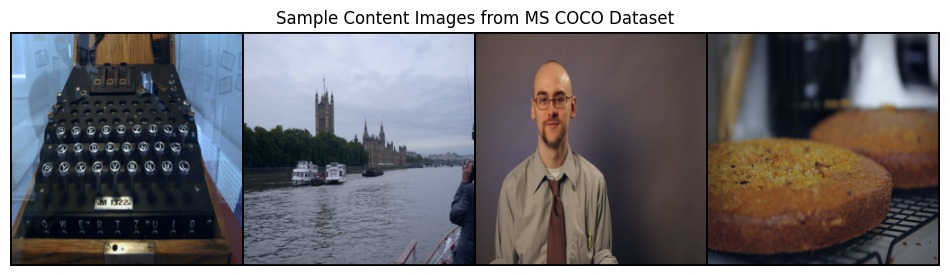

In [6]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_batch(batch_tensor, title="Batch of Images"):
    grid_img = vutils.make_grid(batch_tensor, nrow=4, padding=2, normalize=True)
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()  # CHW -> HWC
    plt.figure(figsize=(12, 6))
    plt.imshow(np_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

for batch in train_loader:
    show_batch(batch, title="Sample Content Images from MS COCO Dataset")
    break

# Transform Network

In [53]:
import torch
import torch.nn as nn

# Helper blocks
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, relu=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels, affine=True)
        ]
        if relu:
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvLayer(channels, channels, kernel_size=3, stride=1, padding=1),
            ConvLayer(channels, channels, kernel_size=3, stride=1, padding=1, relu=False)
        )

    def forward(self, x):
        return x + self.block(x)

class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=upsample, mode='nearest') if upsample else nn.Identity(),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, kernel_size // 2),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class TransformNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial layers
        self.initial = nn.Sequential(
            ConvLayer(3, 32, kernel_size=9, stride=1, padding=4),
            ConvLayer(32, 64, kernel_size=3, stride=2, padding=1),
            ConvLayer(64, 128, kernel_size=3, stride=2, padding=1)
        )

        # Residual blocks
        self.residuals = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128)
        )

        # Upsampling
        self.upsample = nn.Sequential(
            UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2),
            UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2),
            nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4),
            # nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.residuals(x)
        x = self.upsample(x)
        return x


# Perceptual Loss Network

In [54]:
from collections import namedtuple

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

# Define which layers to use
CONTENT_LAYER = 'relu2_2'
STYLE_LAYERS = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']


class PerceptualLossNet(nn.Module):
    """
    Perceptual loss network leveraging pretrained VGG-16
    """
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights=VGG16_Weights.DEFAULT).eval()
        vgg_features = vgg.features
        self.layer_names = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']

        # Slices for each block/layer
        self.slice1 = nn.Sequential(*vgg_features[:4])   # relu1_2
        self.slice2 = nn.Sequential(*vgg_features[4:9])  # relu2_2
        self.slice3 = nn.Sequential(*vgg_features[9:16]) # relu3_3
        self.slice4 = nn.Sequential(*vgg_features[16:23])# relu4_3

        # Freeze VGG params
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        relu1_2 = h
        h = self.slice2(h)
        relu2_2 = h
        h = self.slice3(h)
        relu3_3 = h
        h = self.slice4(h)
        relu4_3 = h
        vgg_output = namedtuple("VGGOutput", self.layer_names)
        return vgg_output(relu1_2, relu2_2, relu3_3, relu4_3)

def gram_matrix(feat):
    b, c, h, w = feat.size()
    f = feat.view(b, c, h * w)
    return torch.bmm(f, f.transpose(1, 2)) / (c * h * w)


# Training

In [67]:
import os

# dataset_path = os.path.join(os.path.dirname(__file__), 'data', 'mscoco')
# style_images_path = os.path.join(os.path.dirname(__file__), 'data', 'style-images')
# model_binaries_path = os.path.join(os.path.dirname(__file__), 'models', 'binaries')
# checkpoints_root_path = os.path.join(os.path.dirname(__file__), 'models', 'checkpoints')

# os.makedirs(model_binaries_path, exist_ok=True)

training_config = {
    'image_size': IMAGE_SIZE, # training images from MS COCO are resized to image_size x image_size
    'batch_size': BATCH_SIZE,
    'num_epochs': 1,
    'lr': 1e-3,
    'style_weight': 4e5,
    'content_weight': 1e0,
    'style_image_path': '/content/drive/MyDrive/nst/style-images/mosaic.jpg',
    'save_model': True,
    'model_state_dict': '/content/drive/MyDrive/nst/models',
    # logging/debugging/checkpoint related (helps a lot with experimentation)
    'enable_tensorboard': True, # enable tensorboard logging (scalars + images)
    'image_log_freq': 100, # tensorboard image logging (batch) frequency - enable_tensorboard must be True to use
    'console_log_freq': 500, # logging to output console (batch) frequency
    'checkpoint_freq': 2000 # checkpoint model saving (batch) frequency
}

# TODO: Load the dataset here (maybe)

In [68]:
from PIL import Image
from torchvision import transforms
import torch

def load_style_image(image_path, image_size=256, normalize=True, is_255_range=False, device='cuda'):
    transform_list = [
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),  # Scales to [0, 1]
    ]

    if is_255_range:
        transform_list.append(transforms.Lambda(lambda x: x.mul(255)))
    if normalize:
        transform_list.append(transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL) if is_255_range else transforms.Normalize(mean=IMAGENET_MEAN_1, std=IMAGENET_STD_1))
    transform = transforms.Compose(transform_list)

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Shape: [1, 3, H, W]
    return image_tensor


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def train(dataloader, training_config, log_interval=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize models
    transform_net = TransformNet().to(device)
    perceptual_net = PerceptualLossNet().to(device)
    perceptual_net.eval()

    # Optimizer and loss function
    optimizer = optim.Adam(transform_net.parameters(), lr=training_config['lr'])
    mse_loss = nn.MSELoss(reduction='mean')

    # Load and process style image (ImageNet normalization)
    style_image = load_style_image(training_config['style_image_path'], image_size=training_config['image_size'], device=device)
    style_batch = style_image.repeat(training_config['batch_size'], 1, 1, 1)

    # Extract target style representations (Gram matrices)
    style_features = perceptual_net(style_batch)
    target_style_grams = [gram_matrix(fmap) for fmap in style_features]

    transform_net.train()
    for epoch in range(training_config['num_epochs']):
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{training_config['num_epochs']}")
        for batch_idx, content_batch in enumerate(progress_bar):
            content_batch = content_batch.to(device)

            optimizer.zero_grad()
            # Step 1: Generate stylized images
            stylized_batch = transform_net(content_batch)

            # Step 2: Extract features using perceptual network (VGG-16)
            content_features = perceptual_net(content_batch)
            stylized_features = perceptual_net(stylized_batch)

            # Step 3: Compute content loss (using relu2_2 layer)
            target_content = content_features.relu2_2
            generated_content = stylized_features.relu2_2
            content_loss = training_config['content_weight'] * mse_loss(generated_content, target_content)

            # Step 4: Compute style loss using Gram matrices
            style_loss = 0.0
            stylized_grams = [gram_matrix(fmap) for fmap in stylized_features]
            for stylized_gram, target_gram in zip(stylized_grams, target_style_grams):
                style_loss += mse_loss(stylized_gram, target_gram)
            style_loss = (training_config['style_weight']) * (style_loss / len(target_style_grams))


            # Step 5: Compute total variation loss - enforces image smoothness
            tv_loss = 0 # TODO: Implement total variation loss if needed

            # Step 6: Combine losses and backpropagate
            total_loss = content_loss + style_loss + tv_loss
            total_loss.backward()
            optimizer.step()

            # Logging
            if batch_idx % log_interval == 0:
                progress_bar.set_postfix({
                    "Total Loss": f"{total_loss.item():.2f}",
                    "Content Loss": f"{content_loss.item():.2f}",
                    "Style Loss": f"{style_loss.item():.2f}"
                })

        if training_config.get('save_model', True):
            save_path = training_config.get("model_save_path", "style_transfer_model.pth")
            torch.save({
                'model_state_dict': transform_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'training_config': training_config,
            }, save_path)

    # torch.save({
    #     'model_state_dict': style_transfer_model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'training_config': training_config,
    # }, 'style_transfer_model.pth')

    # TODO: Integrate TensorBoard logging if needed

    return transform_net, optimizer

transform_net, optimizer = train(train_loader, training_config)

Epoch 1/1: 100%|██████████| 500/500 [00:23<00:00, 20.99it/s, Total Loss=25.36, Content Loss=17.26, Style Loss=8.10]


In [76]:
model_path = "fast_style_model.pth"
torch.save(transform_net.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to fast_style_model.pth


# Inference

In [ ]:
# Load the saved model

In [77]:
def stylize_image(model, input_image_path, output_image_path, device):
    model.eval()
    image = Image.open(input_image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image).cpu().squeeze(0)
        output = output * 0.5 + 0.5  # unnormalize
        output_image = transforms.ToPILImage()(output.clamp(0, 1))
        output_image.save(output_image_path)
        print(f"Saved stylized image to {output_image_path}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_image_path_1 = '/content/drive/MyDrive/nst/content-images/lion.jpg'
input_image_path_2 = '/content/drive/MyDrive/nst/content-images/dog.jpg'
input_image_path_3 = '/content/drive/MyDrive/nst/content-images/ortakoy_istanbul.jpg'

output_image_path = '/content/stylized_output.jpg'

stylize_image(transform_net, input_image_path_1, output_image_path, device)

Saved stylized image to /content/stylized_output.jpg


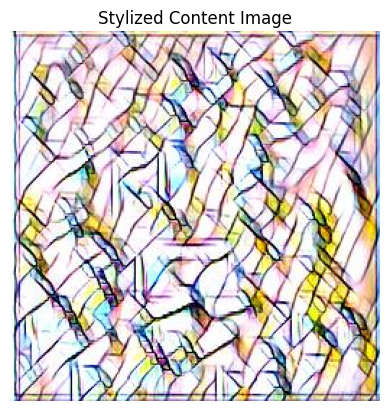

In [78]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

def load_image(path, max_size=512, shape=None):
    image = Image.open(path).convert('RGB')

    # Resize
    if max_size:
        size = min(max(image.size), max_size)
        transform = transforms.Resize(size)
        image = transform(image)

    if shape:
        transform = transforms.Resize(shape)
        image = transform(image)

    # Transform to tensor
    transform = transforms.ToTensor()
    image = transform(image).unsqueeze(0)  # Add batch dimension

    return image


def imshow(tensor, title=None):
    image = tensor.clone().detach().cpu().squeeze(0)  # remove batch dimension
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# TODO: Show (Style, Content, Stylized_Output)
image = load_image(output_image_path)
imshow(image, title="Stylized Content Image")